In [1]:
import os, json, random
from pathlib import Path
from collections import Counter, defaultdict

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import pprint
pp = pprint.PrettyPrinter(indent=2, width=120)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [7]:
ROOT = Path("../gqa")
IMAGES = ROOT / "images"
QUESTIONS = ROOT / "questions"
SCENES = ROOT / "scene_graphs"

print("GQA structure:")
print(f"    Images: {IMAGES.exists()} - {len(list(IMAGES.glob('*.jpg'))) if IMAGES.exists() else 0} files")
print(f"    Questions: {QUESTIONS.exists()} - {len(list(QUESTIONS.glob('*.json'))) if QUESTIONS.exists() else 0} files")
print(f"    Scenes: {SCENES.exists()} - {len(list(SCENES.glob('*.json'))) if SCENES.exists() else 0} files")
print()

if QUESTIONS.exists():
    print("Available question files:")
    for f in sorted(QUESTIONS.glob("*.json")):
        print(f"    {f.name}")
        
print()
if SCENES.exists():
    print("Available scene graph files:")
    for f in sorted(SCENES.glob("*.json")):
        print(f"    {f.name}")

GQA structure:
    Images: True - 148854 files
    Questions: True - 3 files
    Scenes: True - 2 files

Available question files:
    test_balanced_questions.json
    train_balanced_questions.json
    val_balanced_questions.json

Available scene graph files:
    train_sceneGraphs.json
    val_sceneGraphs.json
    Images: True - 148854 files
    Questions: True - 3 files
    Scenes: True - 2 files

Available question files:
    test_balanced_questions.json
    train_balanced_questions.json
    val_balanced_questions.json

Available scene graph files:
    train_sceneGraphs.json
    val_sceneGraphs.json


In [4]:
def load_gqa_questions(path, limit=None):
    with open(path, "r") as file:
        data = json.load(file)

    if limit:
        question_ids = list(data.keys())[:limit]
        data = {qid: data[qid] for qid in question_ids}
    return data

SAMPLE_SIZE = 5000
q_train_dict = load_gqa_questions(QUESTIONS / "train_balanced_questions.json", SAMPLE_SIZE)
q_val_dict = load_gqa_questions(QUESTIONS / "val_balanced_questions.json", SAMPLE_SIZE // 5)

In [5]:
keys = list(q_train_dict.keys())
id = random.randint(0, len(keys) - 1)
sample_id = keys[id]
sample_q = q_train_dict[sample_id]

print("Example of GQA structure")
print()
print(f"Question ID: {sample_id}")
print()
pp.pprint(sample_q)

Example of GQA structure

Question ID: 07832171

{ 'annotations': {'answer': {}, 'fullAnswer': {}, 'question': {}},
  'answer': 'station',
  'entailed': ['07832172'],
  'equivalent': ['07832171'],
  'fullAnswer': 'It is a station.',
  'groups': {'global': 'place', 'local': '02q-place'},
  'imageId': '2354317',
  'isBalanced': True,
  'question': 'What place is it?',
  'semantic': [ {'argument': 'scene', 'dependencies': [], 'operation': 'select'},
                {'argument': 'place', 'dependencies': [0], 'operation': 'query'}],
  'semanticStr': 'select: scene->query: place [0]',
  'types': {'detailed': 'place', 'semantic': 'global', 'structural': 'query'}}


In [6]:
questions_list = []

for qid, q_data in q_train_dict.items():
    q_data['questionId'] = qid # additional field
    q_data['split'] = 'train'
    questions_list.append(q_data)

for qid, q_data in q_val_dict.items():
    q_data['questionId'] = qid
    q_data['split'] = 'val'
    questions_list.append(q_data)

sample_id = random.randint(0, len(questions_list) - 1)
sample = questions_list[sample_id]
print("Available fields in GQA question:")
for key in sample.keys():
    print(f"  - {key}")


Available fields in GQA question:
  - semantic
  - entailed
  - equivalent
  - question
  - imageId
  - isBalanced
  - groups
  - answer
  - semanticStr
  - annotations
  - types
  - fullAnswer
  - questionId
  - split


## Basic Question Analysis

In [9]:
question_texts = [q['question'] for q in questions_list]
answers = [q.get('answer', 'N/A') for q in questions_list]
image_ids = [q['imageId'] for q in questions_list]
types = [q.get('types', {}) for q in questions_list]

print("Basic Statistics:")
print(f"    Total questions: {len(questions_list)}")
print(f"    Unique images: {len(set(image_ids))}")
print(f"    Avg questions per image: {len(questions_list) / len(set(image_ids)):.2f}")
print()

answer_counts = Counter(answers)
print(f"Unique answers: {len(answer_counts)}")
print(f"Top 10 most common answers:")
for ans, cnt in answer_counts.most_common(10):
    pct = (cnt / len(answers)) * 100
    print(f"    '{ans}': {cnt} ({pct:.2f}%)")
print()

question_lengths = [len(q.split()) for q in question_texts]
print(f"Question length (words):")
print(f"    Mean: {np.mean(question_lengths):.2f}")
print(f"    Median: {np.median(question_lengths):.0f}")
print(f"    Min: {np.min(question_lengths)}")
print(f"    Max: {np.max(question_lengths)}")

Basic Statistics:
    Total questions: 6000
    Unique images: 4600
    Avg questions per image: 1.30

Unique answers: 641
Top 10 most common answers:
    'yes': 1099 (18.32%)
    'no': 1017 (16.95%)
    'left': 315 (5.25%)
    'right': 298 (4.97%)
    'man': 75 (1.25%)
    'black': 69 (1.15%)
    'white': 67 (1.12%)
    'woman': 61 (1.02%)
    'blue': 58 (0.97%)
    'bottom': 58 (0.97%)

Question length (words):
    Mean: 8.81
    Median: 8
    Min: 3
    Max: 24


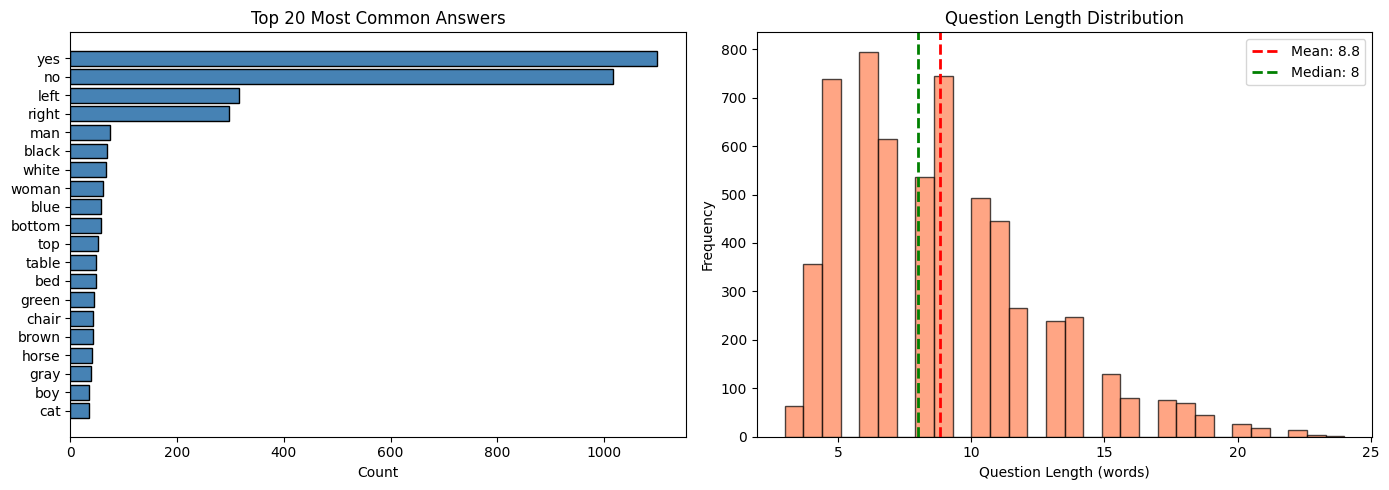

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

top_answers = answer_counts.most_common(20)
ans_labels, ans_counts = zip(*top_answers)
axes[0].barh(range(len(ans_labels)), ans_counts, color='steelblue', edgecolor='black')
axes[0].set_yticks(range(len(ans_labels)))
axes[0].set_yticklabels(ans_labels)
axes[0].set_xlabel('Count')
axes[0].set_title('Top 20 Most Common Answers')
axes[0].invert_yaxis()

axes[1].hist(question_lengths, bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(question_lengths), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(question_lengths):.1f}')
axes[1].axvline(np.median(question_lengths), color='green', linestyle='--', linewidth=2,
                label=f'Median: {np.median(question_lengths):.0f}')
axes[1].set_xlabel('Question Length (words)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Question Length Distribution')
axes[1].legend()


plt.tight_layout()
plt.show()

## Question Types Analysis 

In [30]:
semantic_types = []
structural_types = []

for q in questions_list:
    q_types = q.get('types', {})

    sem = q_types.get("semantic", None)
    if sem is not None:
        if isinstance(sem, str):
            semantic_types.append(sem)
        else:
            semantic_types.extend(sem)

    struct = q_types.get('structural', None)
    if struct is not None:
        if isinstance(sem, str):
            structural_types.append(struct)
        else:
            structural_types.extend(struct)
            
semantic_counts = Counter(semantic_types)
structural_counts = Counter(structural_types)

print("GQA question types")
print()

print(f"SEMANTIC TYPES ({len(semantic_counts)} unique):")
for qtype, count in semantic_counts.most_common(15):
    pct = (count / len(semantic_types)) * 100 if semantic_types else 0
    print(f"    {qtype}: {count:} ({pct:.2f}%)")

print()
print(f"STRUCTURAL TYPES ({len(structural_counts)} unique):")
for qtype, count in structural_counts.most_common(15):
    pct = (count / len(structural_types)) * 100 if structural_types else 0
    print(f"    {qtype}: {count:} ({pct:.2f}%)")

GQA question types

SEMANTIC TYPES (5 unique):
    rel: 2874 (47.90%)
    attr: 1856 (30.93%)
    obj: 692 (11.53%)
    cat: 380 (6.33%)
    global: 198 (3.30%)

STRUCTURAL TYPES (5 unique):
    query: 3110 (51.83%)
    verify: 1296 (21.60%)
    choose: 728 (12.13%)
    logical: 693 (11.55%)
    compare: 173 (2.88%)


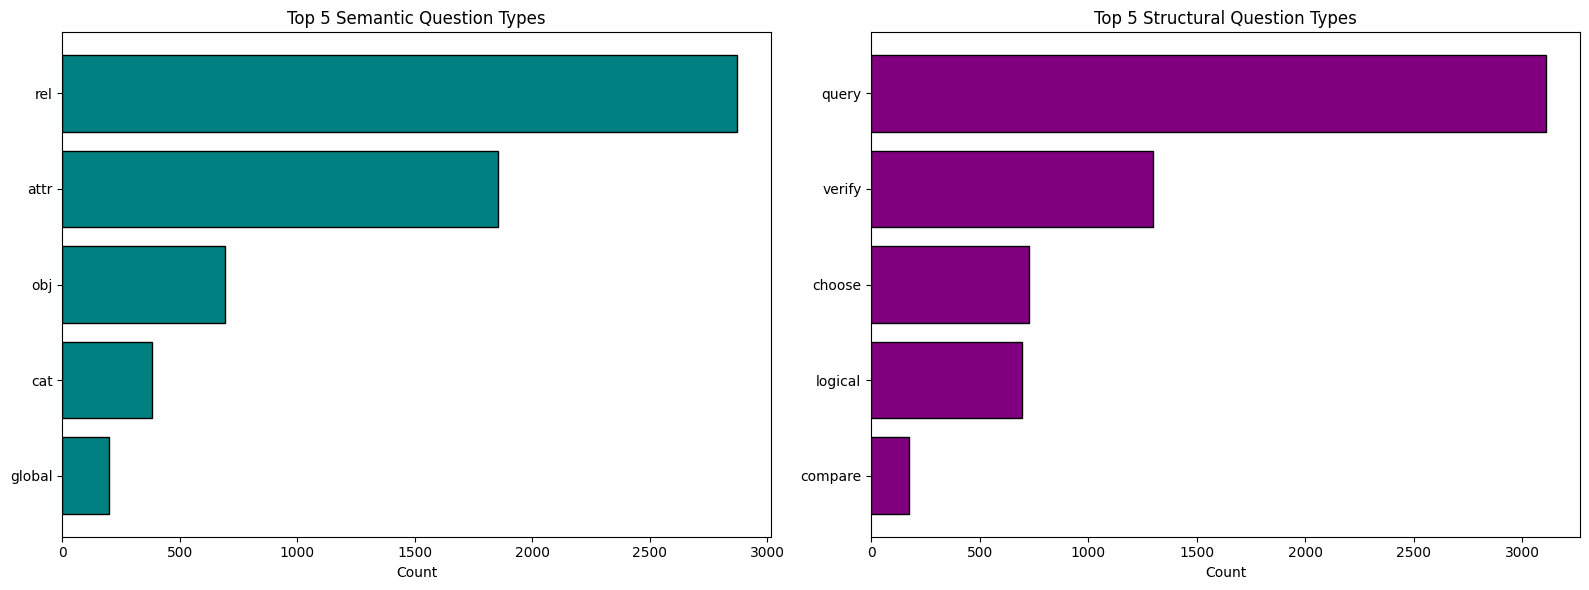

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

if semantic_counts:
    top_semantic = semantic_counts.most_common(5)
    sem_labels, sem_counts = zip(*top_semantic)
    axes[0].barh(range(len(sem_labels)), sem_counts, color='teal', edgecolor='black')
    axes[0].set_yticks(range(len(sem_labels)))
    axes[0].set_yticklabels(sem_labels)
    axes[0].set_xlabel('Count')
    axes[0].set_title('Top 5 Semantic Question Types')
    axes[0].invert_yaxis()

if structural_counts:
    top_structural = structural_counts.most_common(5)
    str_labels, str_counts = zip(*top_structural)
    axes[1].barh(range(len(str_labels)), str_counts, color='purple', edgecolor='black')
    axes[1].set_yticks(range(len(str_labels)))
    axes[1].set_yticklabels(str_labels)
    axes[1].set_xlabel('Count')
    axes[1].set_title('Top 5 Structural Question Types')
    axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## Scene Graphs Analysis - sample

In [21]:
def load_gqa_scenes(path, limit=100):
    with open(path, "r") as f:
        data = json.load(f)

    scene_ids = list(data.keys())[:limit]
    data = {sid: data[sid] for sid in scene_ids}

    return data

scenes_dict = load_gqa_scenes(SCENES / "train_sceneGraphs.json", limit=100)

In [22]:
id = random.randint(0, len(scenes_dict) - 1)
sample_scene_id = list(scenes_dict.keys())[id]
sample_scene = scenes_dict[sample_scene_id]

print(f"GQA scene graph structure (Scene {sample_scene_id})")

print()
pp.pprint(sample_scene)

GQA scene graph structure (Scene 2323928)

{ 'height': 333,
  'objects': { '2942875': {'attributes': [], 'h': 157, 'name': 'bear', 'relations': [], 'w': 224, 'x': 110, 'y': 112},
               '3139589': { 'attributes': [],
                            'h': 92,
                            'name': 'head',
                            'relations': [ {'name': 'to the left of', 'object': '3190545'},
                                           {'name': 'to the left of', 'object': '3661904'},
                                           {'name': 'to the left of', 'object': '3234309'}],
                            'w': 106,
                            'x': 116,
                            'y': 114},
               '3190545': { 'attributes': [],
                            'h': 62,
                            'name': 'doll',
                            'relations': [ {'name': 'wearing', 'object': '3661904'},
                                           {'name': 'to the right of', 'object': '3139589'

In [41]:
total_objects = 0
object_names = []
object_attributes = []

for scene_id, scene_data in scenes_dict.items():
    objects = scene_data.get('objects', {})
    total_objects += len(objects)
    
    for obj_id, obj_data in objects.items():
        if 'name' in obj_data:
            object_names.append(obj_data['name'])
        if 'attributes' in obj_data:
            object_attributes.extend(obj_data['attributes'])

name_counts = Counter(object_names)
attr_counts = Counter(object_attributes)

print("Scene graph statistics")
print()
print(f"Scenes analyzed: {len(scenes_dict)}")
print(f"Total objects: {total_objects}")
print(f"Avg objects per scene: {total_objects / len(scenes_dict):.2f}")
print(f"Unique object names: {len(name_counts)}")
print(f"Unique attributes: {len(attr_counts)}")
print()

print("Top 20 object names:")
for name, count in name_counts.most_common(20):
    print(f"    {name}: {count:}")

print()
print("Top 20 attributes:")
for attr, count in attr_counts.most_common(20):
    print(f"    {attr}: {count}")

Scene graph statistics

Scenes analyzed: 100
Total objects: 1546
Avg objects per scene: 15.46
Unique object names: 409
Unique attributes: 162

Top 20 object names:
    tree: 45
    window: 34
    shirt: 32
    man: 29
    building: 25
    sign: 24
    car: 24
    wall: 23
    ground: 22
    sky: 22
    leg: 21
    person: 20
    pole: 19
    leaves: 18
    head: 18
    grass: 16
    trees: 16
    hand: 15
    chair: 15
    hat: 14

Top 20 attributes:
    white: 117
    green: 78
    black: 60
    blue: 47
    brown: 44
    red: 43
    small: 29
    yellow: 25
    orange: 24
    gray: 20
    large: 18
    wood: 16
    long: 15
    tall: 14
    silver: 13
    metal: 12
    eating: 9
    pink: 9
    parked: 8
    open: 8


## Example questions from different categories

In [39]:
questions_by_type = defaultdict(list)

for q in questions_list:
    sem_types = q.get('types', {}).get('semantic', None)
    if sem_types is None:
        continue

    if isinstance(sem_types, str): # in case it's a single type
        sem_types = [sem_types]

    for stype in sem_types:
        questions_by_type[stype].append(q)

for qtype in list(semantic_counts.keys())[:5]:
    examples = questions_by_type[qtype][:2]
    
    print()
    print(f"Type: {qtype}")
    
    for i, ex in enumerate(examples, 1):
        print(f"\nExample {i}:")
        print(f"    Question: {ex['question']}")
        print(f"    Answer: {ex.get('answer', 'N/A')}")
        print(f"    Image: {ex['imageId']}")
        print(f"    Full answer: {ex.get('fullAnswer', 'N/A')}")
        
        sem = ex.get('types', {}).get('semantic', [])
        struct = ex.get('types', {}).get('structural', [])
        print(f"    Semantic types: {sem}")
        print(f"    Structural types: {struct}")



Type: attr

Example 1:
    Question: Is the sky dark?
    Answer: yes
    Image: 2354786
    Full answer: Yes, the sky is dark.
    Semantic types: attr
    Structural types: verify

Example 2:
    Question: Is that pipe red?
    Answer: no
    Image: 2375429
    Full answer: No, the pipe is white.
    Semantic types: attr
    Structural types: verify

Type: rel

Example 1:
    Question: What is on the white wall?
    Answer: pipe
    Image: 2375429
    Full answer: The pipe is on the wall.
    Semantic types: rel
    Structural types: query

Example 2:
    Question: Who is wearing a shirt?
    Answer: girl
    Image: 2331819
    Full answer: The girl is wearing a shirt.
    Semantic types: rel
    Structural types: query

Type: obj

Example 1:
    Question: Are there any red umbrellas or motorcycles in the photograph?
    Answer: yes
    Image: 2377188
    Full answer: Yes, there is a red motorcycle.
    Semantic types: obj
    Structural types: logical

Example 2:
    Question: Is t

In [40]:
questions_by_struct = defaultdict(list)

for q in questions_list:
    struct_types = q.get('types', {}).get('structural', None)
    if struct_types is None:
        continue

    if isinstance(struct_types, str):
        struct_types = [struct_types]

    for stype in struct_types:
        questions_by_struct[stype].append(q)

for qtype in list(structural_counts.keys())[:5]:
    examples = questions_by_struct[qtype][:2]

    print()
    print(f"STRUCTURAL TYPE: {qtype}")

    for i, ex in enumerate(examples, 1):
        print(f"\nExample {i}:")
        print(f"    Question: {ex['question']}")
        print(f"    Answer: {ex.get('answer', 'N/A')}")
        print(f"    Image: {ex['imageId']}")
        print(f"    Full answer: {ex.get('fullAnswer', 'N/A')}")
        sem = ex.get('types', {}).get('semantic', [])
        struct = ex.get('types', {}).get('structural', [])
        print(f"    Semantic types: {sem}")
        print(f"    Structural types: {struct}")


STRUCTURAL TYPE: verify

Example 1:
    Question: Is the sky dark?
    Answer: yes
    Image: 2354786
    Full answer: Yes, the sky is dark.
    Semantic types: attr
    Structural types: verify

Example 2:
    Question: Is that pipe red?
    Answer: no
    Image: 2375429
    Full answer: No, the pipe is white.
    Semantic types: attr
    Structural types: verify

STRUCTURAL TYPE: query

Example 1:
    Question: What is on the white wall?
    Answer: pipe
    Image: 2375429
    Full answer: The pipe is on the wall.
    Semantic types: rel
    Structural types: query

Example 2:
    Question: Who is wearing a shirt?
    Answer: girl
    Image: 2331819
    Full answer: The girl is wearing a shirt.
    Semantic types: rel
    Structural types: query

STRUCTURAL TYPE: choose

Example 1:
    Question: Is the tall clock small or large?
    Answer: large
    Image: 2368326
    Full answer: The clock is large.
    Semantic types: attr
    Structural types: choose

Example 2:
    Question: Is

## Scene Graph Structure Analysis

In [37]:
all_attributes = defaultdict(int)
all_relations = defaultdict(int)

for _, scene in scenes_dict.items():
    objs = scene.get('objects', {})
    
    for obj_id, obj in objs.items():
        attrs = obj.get('attributes', [])
        for attr in attrs:
            all_attributes[attr] += 1

        rels = obj.get('relations', [])
        for rel in rels:
            rel_name = rel.get('name', 'unknown')
            all_relations[rel_name] += 1

sorted_attrs = sorted(all_attributes.items(), key=lambda x: x[1], reverse=True)
sorted_rels = sorted(all_relations.items(), key=lambda x: x[1], reverse=True)

print(f"\nTop 20 Object Attributes:")
for attr, count in sorted_attrs[:20]:
    print(f"    {attr}: {count}")

print(f"\nTop 20 Spatial Relations:")
for rel, count in sorted_rels[:20]:
    print(f"    {rel}: {count}")

print(f"\nTotal unique attributes: {len(all_attributes)}")
print(f"Total unique relations: {len(all_relations)}")


Top 20 Object Attributes:
    white: 117
    green: 78
    black: 60
    blue: 47
    brown: 44
    red: 43
    small: 29
    yellow: 25
    orange: 24
    gray: 20
    large: 18
    wood: 16
    long: 15
    tall: 14
    silver: 13
    metal: 12
    eating: 9
    pink: 9
    parked: 8
    open: 8

Top 20 Spatial Relations:
    to the left of: 2060
    to the right of: 2060
    on: 131
    wearing: 61
    in: 52
    near: 45
    of: 33
    in front of: 19
    behind: 19
    next to: 16
    above: 12
    inside: 10
    with: 9
    by: 9
    holding: 9
    beside: 8
    riding: 7
    sitting on: 7
    at: 7
    on top of: 6

Total unique attributes: 162
Total unique relations: 61


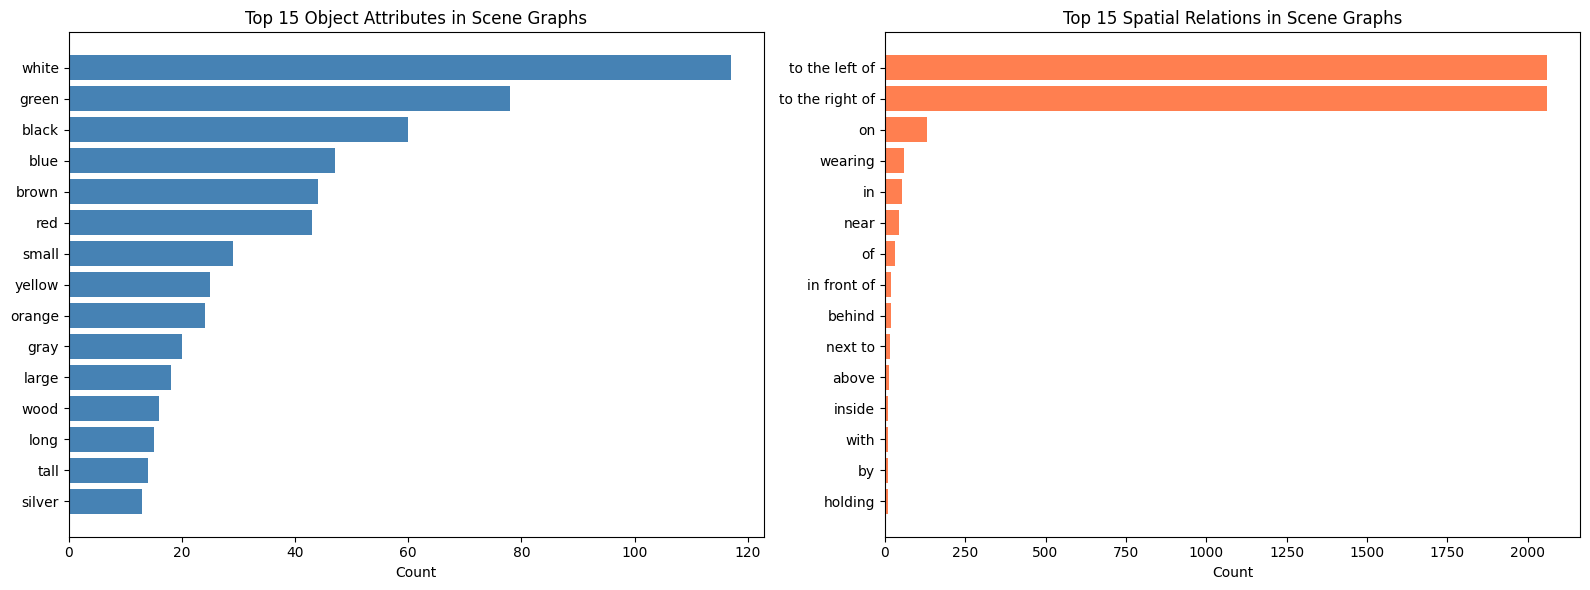

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_attrs = sorted_attrs[:15]
attrs_names = [a[0] for a in top_attrs]
attrs_counts = [a[1] for a in top_attrs]

axes[0].barh(range(len(attrs_names)), attrs_counts, color='steelblue')
axes[0].set_yticks(range(len(attrs_names)))
axes[0].set_yticklabels(attrs_names)
axes[0].set_xlabel('Count')
axes[0].set_title('Top 15 Object Attributes in Scene Graphs')
axes[0].invert_yaxis()

top_rels = sorted_rels[:15]
rels_names = [r[0] for r in top_rels]
rels_counts = [r[1] for r in top_rels]

axes[1].barh(range(len(rels_names)), rels_counts, color='coral')
axes[1].set_yticks(range(len(rels_names)))
axes[1].set_yticklabels(rels_names)
axes[1].set_xlabel('Count')
axes[1].set_title('Top 15 Spatial Relations in Scene Graphs')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## Visual Example: Question with Scene Graph and Image

DETAILED EXAMPLE: Question + Scene Graph + Image

Question: Is the white food to the left or to the right of the bowl?
Answer: left
Full Answer: The rice is to the left of the bowl.
Image ID: 2386621

Semantic Types: rel
Structural Types: choose

Scene Graph Info:
    Number of objects: 16
    Image width: 500
    Image height: 375

Sample objects from scene:

Object 1 (ID: 681267):
    Name: banana
    Attributes: ['small', 'yellow']
    Bounding box: x=248, y=55, w=64, h=34
    Relations: ['to the left of']

Object 2 (ID: 681265):
    Name: spots
    Attributes: []
    Bounding box: x=245, y=92, w=26, h=16

Object 3 (ID: 681264):
    Name: bananas
    Attributes: ['small', 'yellow']
    Bounding box: x=268, y=32, w=49, h=50
    Relations: ['to the left of']


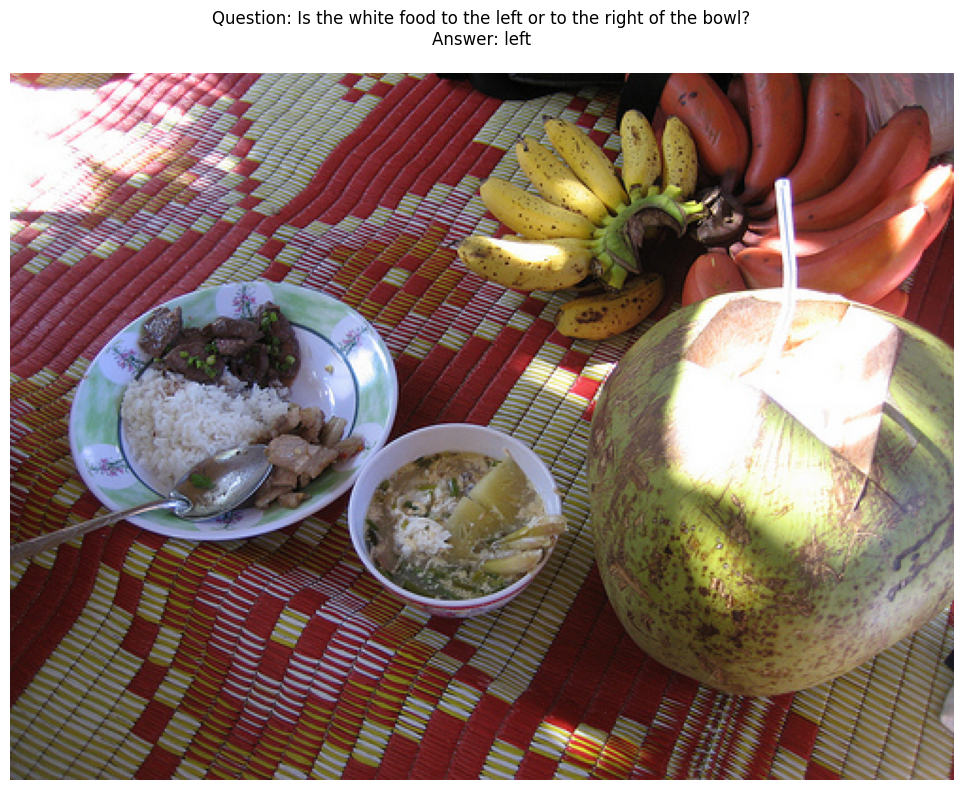

In [51]:
sample_question = None
for q in questions_list:
    img_id = q['imageId']
    if img_id in scenes_dict:
        img_path = IMAGES / f"{img_id}.jpg"
        if img_path.exists():
            sample_question = q
            break

if sample_question:
    img_id = sample_question['imageId']
    scene = scenes_dict[img_id]
    
    print("DETAILED EXAMPLE: Question + Scene Graph + Image")
    
    print(f"\nQuestion: {sample_question['question']}")
    print(f"Answer: {sample_question.get('answer', 'N/A')}")
    print(f"Full Answer: {sample_question.get('fullAnswer', 'N/A')}")
    print(f"Image ID: {img_id}")

    print(f"\nSemantic Types: {sample_question.get('types', {}).get('semantic', [])}")
    print(f"Structural Types: {sample_question.get('types', {}).get('structural', [])}")
    
    objs = scene.get('objects', {})
    print(f"\nScene Graph Info:")
    print(f"    Number of objects: {len(objs)}")
    print(f"    Image width: {scene.get('width', 'N/A')}")
    print(f"    Image height: {scene.get('height', 'N/A')}")
    
    print(f"\nSample objects from scene:")
    for i, (obj_id, obj) in enumerate(list(objs.items())[:3]):
        print(f"\nObject {i+1} (ID: {obj_id}):")
        print(f"    Name: {obj.get('name', 'N/A')}")
        print(f"    Attributes: {obj.get('attributes', [])}")
        print(f"    Bounding box: x={obj.get('x', 'N/A')}, y={obj.get('y', 'N/A')}, w={obj.get('w', 'N/A')}, h={obj.get('h', 'N/A')}")
        rels = obj.get('relations', [])
        if rels:
            print(f"    Relations: {[r.get('name') for r in rels[:3]]}")
    
    img_path = IMAGES / f"{img_id}.jpg"
    img = Image.open(img_path)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Question: {sample_question['question']}\nAnswer: {sample_question.get('answer', 'N/A')}", 
              fontsize=12, pad=20)
    plt.tight_layout()
    plt.show()
else:
    print("Could not find a question with both scene graph and image available in the sample.")

## Summary statistics

In [60]:
unique_images = len(set(image_ids))
unique_answers = len(answer_counts)
avg_question_lenght = np.mean(question_lengths)
median_question_lenght = np.median(question_lengths)
longest_question = np.max(question_lengths)
shortest_question= np.min(question_lengths)
most_common_answer, most_common_answer_cnt = answer_counts.most_common(1)[0]
avg_objects = total_objects / len(scenes_dict)
most_common_object, most_common_object_cnt = name_counts.most_common(1)[0]

In [62]:
print("\nDATASET OVERVIEW:")
print(f"    Total questions analyzed: {len(questions_list)}")
print(f"    Total unique images: {unique_images}")
print(f"    Total unique answers: {unique_answers}")
print(f"    Scene graphs analyzed: {len(scenes_dict)}")

print("\nQUESTION CHARACTERISTICS:")
print(f"    Average question length: {avg_question_lenght:.1f} characters")
print(f"    Median question length: {median_question_lenght:.2f} characters")
print(f"    Shortest question: {shortest_question} characters")
print(f"    Longest question: {longest_question} characters")

print("\nANSWER DISTRIBUTION:")
print(f"    Most common answer: '{most_common_answer}' ({most_common_answer_cnt} occurrences)")
print(f"    Answer diversity (unique/total): {unique_answers/len(questions_list):.2%}")

print("\nQUESTION TYPES:")
print(f"    Unique semantic types: {len(semantic_counts)}")
print(f"    Unique structural types: {len(structural_counts)}")
print(f"    Top 5 semantic types:")
for qtype, count in list(semantic_counts.items())[:5]:
    print(f"    - {qtype}: {count} ({count/len(questions_list):.1%})")

print("\nSCENE GRAPH STRUCTURE:")
print(f"    Average objects per scene: {avg_objects:.1f}")
print(f"    Total unique object names: {len(object_names)}")
print(f"    Total unique attributes: {len(all_attributes)}")
print(f"    Total unique relations: {len(all_relations)}")
print(f"    Most common object: '{most_common_object}' ({most_common_object_cnt} occurrences)")
print(f"    Most common attribute: '{sorted_attrs[0][0]}' ({sorted_attrs[0][1]} occurrences)")
print(f"    Most common relation: '{sorted_rels[0][0]}' ({sorted_rels[0][1]} occurrences)")



DATASET OVERVIEW:
    Total questions analyzed: 6000
    Total unique images: 4600
    Total unique answers: 641
    Scene graphs analyzed: 100

QUESTION CHARACTERISTICS:
    Average question length: 8.8 characters
    Median question length: 8.00 characters
    Shortest question: 3 characters
    Longest question: 24 characters

ANSWER DISTRIBUTION:
    Most common answer: 'yes' (1099 occurrences)
    Answer diversity (unique/total): 10.68%

QUESTION TYPES:
    Unique semantic types: 5
    Unique structural types: 5
    Top 5 semantic types:
    - attr: 1856 (30.9%)
    - rel: 2874 (47.9%)
    - obj: 692 (11.5%)
    - cat: 380 (6.3%)
    - global: 198 (3.3%)

SCENE GRAPH STRUCTURE:
    Average objects per scene: 15.5
    Total unique object names: 1546
    Total unique attributes: 162
    Total unique relations: 61
    Most common object: 'tree' (45 occurrences)
    Most common attribute: 'white' (117 occurrences)
    Most common relation: 'to the left of' (2060 occurrences)
